<center>
<h1>
<h1>APM 53674: ALTeGraD</h1>
<h2>Lab Session 4: Distillation and Retrieval Augmented Generation</h2>
<h4>Lecture: Dr. Guokan Shang<br>
Lab: Yang Zhang and Xiao Fei</h4>
<h5>Tuesday, November 18, 2025</h5>
<br>
</center>

<hr style="border:10px solid gray"> </hr>
<p style="text-align: justify;">
This handout includes theoretical introductions, <font color='blue'>coding tasks</font> and <font color='red'>questions</font>. Before the deadline, you should submit <a href='https://forms.gle/9dyaes6dimfvyjwq6' target="_blank">here</a> a <B>.ipynb</B> file named <b>Lastname_Firstname.ipynb</b> containing your notebook (with the gaps filled and your answers to the questions). Your answers should be well constructed and well justified. They should not repeat the question or generalities in the handout. When relevant, you are welcome to include figures, equations and tables derived from your own computations, theoretical proofs or qualitative explanations. One submission is required for each student. The deadline for this lab is <b>Novemver 23
, 2025 11:59 PM</b>. No extension will be granted. Late policy is as follows: ]0, 24] hours late → -5 pts; ]24, 48] hours late → -10 pts; > 48 hours late → not graded (zero).
</p>
<hr style="border:5px solid gray"> </hr>

# Install Requirements

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pathlib

target_dir = pathlib.Path("/content/drive/MyDrive/altegrad_lab5")
target_dir.mkdir(parents=True, exist_ok=True)

target_dir

import sys, os

sys.path.insert(0, str(target_dir))
os.chdir(target_dir)

print("cwd:", os.getcwd())

Mounted at /content/drive
cwd: /content/drive/MyDrive/altegrad_lab5


In [2]:
# Install required dependencies
!pip -q install torch tqdm jsonlines h5py
!pip -q install --upgrade transformers accelerate vllm
!pip install jedi
# !pip -q install datasets==2.21.0 pandas==2.2.2
# !pip -q install chromadb==0.4.22
# !pip -q install "numpy<2.0" --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.3/370.3 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.0/355.0 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.0/183.0 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9

# Part 1 - Model Distillation

> In this section, you’ll learn the difference between **white-box** and **black-box** distillation, generate **synthetic data** to train a **student model**, and implement **white-box distillation** to specialize a model for a **RAG on Wikipedia** use case.


<b><h4><font color='red'>

<hr style="border:10px solid red"> </hr>  
Question 1:</br>
Explain briefly the difference between black-box and white-box distillation? </br> What are the advantages and inconvenients of each approach?
<hr style="border:10px solid red"> </hr>  
</font></h4>

<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 1: </b><br>

White-box distillation is a knowledge distillation method in which the student model distills intrinsic knowledge from the teacher, including logit distributions, hidden states and attention scores [(Chen et al., 2024)](https://arxiv.org/html/2401.07013v2). In this setting, the student model directly mimics the teacher's output distribution and minimizes the distance between the two distributions.

On the other hand, in black-box distillation, the student model learns from the training data generated by teacher model [(Fu et al., 2023)](https://arxiv.org/pdf/2301.12726). The student model only has access to teacher's final output and is therefore trained with supervised fine-tuning on input-output pairs.

Both methods are illustrated in Figure 1 [(Chen et al., 2024)](https://arxiv.org/html/2401.07013v2).

![hey](https://arxiv.org/html/2401.07013v2/x1.png)

Advantages of white-box method:
- Since the student model has insight to teacher's  internal data, it often utlizes richer information and achieves better knowledge transfer [(Wen et al., 2023)](https://arxiv.org/html/2402.13116v1). Moreover, the method uses KL divergence objective which also provides richer supervision signals [(Chen et al., 2024)](https://arxiv.org/html/2401.07013v2).
- Allows full access and control of the teacher, with no need for cloud-service hosting, API calls or external dependencies.  

Limitations of white-box method:
- The method cannot be applied when teacher and student use different vocabularies [(Zhang et al., 2025.)](https://arxiv.org/pdf/2504.11426). It is also challenging to use this method when student's and teacher's tokenizers or model structure differ [(Anon., 2026)](https://openreview.net/pdf/800768a7bd6f7ffe28e947c769affb11d8864a9a.pdf).
- Bridging probability distributions from different output spaces limits how similar the teacher and student can become [(Zhang et al., 2025.)](https://arxiv.org/pdf/2504.11426).
- The performance and ability of the student is bounded by the quality of the teacher model (e.g., a weak teacher limits the student) [(Chen et al., 2024)](https://arxiv.org/html/2401.07013v2).
- The method cannot be used with closed-source models due to restricted access to their internal states (commercial or privacy concerns; [Jin et al., 2022)](https://openreview.net/pdf?id=x8NPd0MFTf).

Advantages of black-box method:
- Since the student model only needs the teacher's final outputs, this method can distill knowledge from large-scale public models (e.g., GPT; [Jin et al., 2022)](https://openreview.net/pdf?id=x8NPd0MFTf).
- Simple, since the student accesses the teacher's data using API queries. Moreover, there is no need to host or store the teacher model.

Limitations of black-box method:
- Innability to utilize the rich knowledge from the intermediate representations of teacher model.
- Due to the lack of access to the teacher's output distribution and internal states and no usage of KL divergence objective, knowledge transfer can be weakened [(Chen et al., 2024)](https://arxiv.org/html/2401.07013v2).
- Dependent on internet and API constraints such as bandwith, rate limits and latency [(Ma et al., 2022)](https://arxiv.org/pdf/2205.10490).
<hr style="border:10px solid green"> </hr>
</font></h4>


<b><h4><font color='red'>

<hr style="border:10px solid red"> </hr>  
Question 2:</br>
What is the main requirement for a teacher/student pair of models to perform white-box distillation?
<hr style="border:10px solid red"> </hr>  
</font></h4>

<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 2: </b><br>

A main requirement for white-box distillation is that the teacher and student should share the same vocabulary [(Zhang et al., 2025.)](https://arxiv.org/pdf/2504.11426). If they have a different vocabulary, the same text can be tokenized into different sequences which results in mismatched token-level distributions. In this case, the KL divergence between their respective distributions is not well-defined.
<hr style="border:10px solid green"> </hr>
</font></h4>



## 1.1 - Synthetic Data Generation

We're going to specialize a small 0.5B parameter model to perform RAG by distilling the abilities of a 7B parameter one.

For that we'll be using `Qwen/Qwen2.5-0.5B-Instruct` as student and `Qwen/Qwen2.5-7B-Instruct-AWQ` (quantized version of `Qwen2.5-7B-Instruct`) as teacher.  

In order to perform white-box distillation on generated answers we have two choices.

1. We can perform a forward pass with the teacher, a forward pass with student on the complete sequence, and backprop difference of logprobs using KL Loss.
2. Generation of samples with the teacher, save the logprobs and perform finetuning in a second step.

<b><h4><font color='red'>

<hr style="border:10px solid red"> </hr>  
Question 3:</br>
What are the computational advantages of 1. vs 2.?
<hr style="border:10px solid red"> </hr>  
</font></h4>

<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 3: </b><br>

Option 1 performs the whole process in a single stage of student training, while option 2 requires two separate stages, which adds extra compute since the dataset needs to be processed twice (once to generate and save teacher logprobs, and once again to train the student), instead of only once.

In option 2, it is required to store the logprobs which adds significant memory overhead and I/O expenses in order to write them after each teacher forward pass and read them back for student training. For large training sets, this also requires external mechanisms to properly manage these files. In option 1, teacher's output is used in "real time" during single training run and discarded once the forward and backward passes are done, thus, it is much more memory and disk efficient.

Finally, in otion 2, if the saved teacher data becomes outdated (e.g., due to changed prompts) before student training, the generation of teacher's samples must be run again. In option 1, the student is always trained on current/updated data, since the teacher is queried "on-the-fly".
<hr style="border:10px solid green"> </hr>
</font></h4>

We're going to generate a bunch of questions related to wikipedia paragraphs.
For that we need to establish a system prompt that will allow for easy extraction.

In [ ]:
system_prompt = """
You are a question generator.
The user will provide:

```json
{"title": "the title of an article", "paragraph": "a paragraph from that article"}
```

Your task:

* Generate one clear, self-contained question that can be answered using only the provided paragraph.
* The question must be **specific**, **unambiguous**, and directly tied to the paragraph’s content.
* Return the result with the question as a valid JSON** in the form:

```json
{
  "question": "your question here"
}
```

Example:
User input:

```json
{
"title": "The Moon Landing",
"paragraph": "On July 20, 1969, Neil Armstrong became the first human to set foot on the Moon, followed by Buzz Aldrin."
}
```
Assistant output:

```json
{
  "question": "Who was the first human to set foot on the Moon during the Apollo 11 mission?"
}
```
"""

<b><h4><font color='red'>

<hr style="border:10px solid red"> </hr>  
Question 4:</br>
In this system prompt, we don't generate answers, only questions. Explain why it's necessary in the context of white-box distillation.
<hr style="border:10px solid red"> </hr>  
</font></h4>

<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 4: </b><br>

The core idea of white-box distillation is that the student model learns from the teacher probability distribution across answer tokens, and not from pre-specified hard labels (e.g. answers). In this case, teacher is already trained on the QA task, and its role now is to provide the rich information (soft labels, logits) to student from which it can learn the same task during distillation. Student, as said before, learns by mimicking the distribution, therefore its supervisor is teacher distribution, not the actual answer label. If we were to include answers, we would practically be doing label-based training and would not primarily rely on the teacher internal distribution. Therefore, we would drift from the white-box and lean toward the black-box distillation.

<hr style="border:10px solid green"> </hr>
</font></h4>

<b><h4><font color='red'>

<hr style="border:10px solid red"> </hr>  
Question 5:</br>
For synthetic data generation we'll be using vLLM.
vLLM is an optimized llm inference engine that can improve generation speed thanks to hardware specific optimization and computational tricks such as Prefix KV Caching.
(https://docs.vllm.ai/en/latest/features/automatic_prefix_caching.html)</br></br> 1. Explain why prefix caching will be very efficient in our case? </br></br>
2. What sampling `temperature` should we use? Justify.



<hr style="border:10px solid red"> </hr>  
</font></h4>


<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 5: </b><br>

1. Each time we generate a question, our vLLM must process the same instruction prompt (`system_prompt`). With APC, `system_prompt` can be processed only once (and cached), so that its KV cache is reused for all future requests. Since the `system_prompt` stays the same across all generation requests and is always present as a prefix to certain paragraph, prefix caching avoids its recomputation and therefore provides higher throughput and lower latency.

2. We want our student model to be trained on diverse set of questions so it can generalize well. Since too low temperature values (\~0) produce more deterministic and repetitive questions, and too high values (\~1) result in unpredictable and out of paragraph domain questions, we should opt for balance between those and choose a moderate temperature, e.g. t=0.7.
<hr style="border:10px solid green"> </hr>
</font></h4>


<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 1: Optimized Generation of Synthetic Questions

Complete the below code with the adequate options (prefix caching and `temperature`)

<hr style="border:10px solid blue"> </hr>
</font></h4>


In [ ]:
import os
os.environ['VLLM_USE_V1'] = '0'
from vllm import LLM
from vllm import SamplingParams
path_teacher = "Qwen/Qwen2.5-7B-Instruct-AWQ"
llm = LLM(model=path_teacher, quantization="awq", gpu_memory_utilization=0.85, max_model_len=5000, enable_prefix_caching=True) # To Complete
sampling_params = SamplingParams(temperature=0.7 , max_tokens=400) # To Complete


INFO 11-22 21:49:27 [utils.py:253] non-default args: {'max_model_len': 5000, 'enable_prefix_caching': True, 'gpu_memory_utilization': 0.85, 'disable_log_stats': True, 'quantization': 'awq', 'model': 'Qwen/Qwen2.5-7B-Instruct-AWQ'}
INFO 11-22 21:49:28 [model.py:631] Resolved architecture: Qwen2ForCausalLM
INFO 11-22 21:49:28 [model.py:1745] Using max model len 5000
INFO 11-22 21:49:33 [scheduler.py:216] Chunked prefill is enabled with max_num_batched_tokens=8192.


Parse safetensors files:   0%|          | 0/2 [00:00<?, ?it/s]

WARNING 11-22 21:49:34 [system_utils.py:103] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reasons: CUDA is initialized
INFO 11-22 21:51:18 [llm.py:352] Supported tasks: ['generate']


<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 2: Question Generation</br>

<hr style="border:10px solid blue"> </hr>
</font></h4>

We're going to use the llm.chat vLLM api to generate our samples.
Make the adequate code to generate the data and save it in a questions.jsonl file.

Entries of jsonl file should look like:
```json
{
  "id_doc": <wikipedia_article_id>,
  "id_paragraph": <paragraph_dataset_id>,
  "question": <generated_question>,
  "title": <title_wikipedia_article>,
  "paragraph": <text_of_paragraph>
}
```

You should:

1. Complete `def extract_question(generated_text: str) -> str:` to extract the generated question.
2. Complete `def conversation_generator` to output a generator directly ingestible by `llm.chat` api
3. Complete the dataloader and for loop to generate samples by batches of 4
4. Save the generated questions in a `questions.jsonl` file

In [ ]:
from typing import Iterable, Iterator, List
import json
def extract_question(generated_text: str) -> str:

    """Extract the question from the generated text. If the question is not\
    following the right format return None."""

    try:
      j: dict
      # To Complete
      generated_text = generated_text.strip()
      # return None if it doesn't follow the format
      if not generated_text.startswith("```json"):
        return None
      if not generated_text.endswith("```"):
        return None
      generated_text = generated_text[len("```json"):-len("```")].strip()
      # print(generated_text)

      j = json.loads(generated_text)
      assert "question" in j.keys()
      return j["question"]
    except (AssertionError, json.JSONDecodeError):
      print("here")
      return None


def conversation_generator(
    entries: Iterable[dict],
    system_prompt: str
    ) -> Iterator[dict]:

    """Generate the conversation with the model."""

    for entry in entries:
      conversation: List[dict] = [
          {"role": "system", "content": system_prompt},
          {"role": "user",
           "content": json.dumps({
                "title": entry["title"],
                "paragraph": entry["paragraph"],
            })
          }
      ]
      # To Complete
      yield conversation

In [ ]:
from torch.utils.data import DataLoader
from datasets import load_dataset

ds = load_dataset("EvanD/Lab4_wikiparagraphs")

batch_size = 4
conversations = list(conversation_generator(ds["train"], system_prompt)) # To Complete

dataloader = DataLoader(conversations, batch_size=batch_size, shuffle=False, num_workers=2, prefetch_factor=2, collate_fn=lambda x: x)


In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'paragraph'],
        num_rows: 200
    })
})

In [ ]:
print(conversations[0])

[{'role': 'system', 'content': '\nYou are a question generator.\nThe user will provide:\n\n```json\n{"title": "the title of an article", "paragraph": "a paragraph from that article"}\n```\n\nYour task:\n\n* Generate one clear, self-contained question that can be answered using only the provided paragraph.\n* The question must be **specific**, **unambiguous**, and directly tied to the paragraph’s content.\n* Return the result with the question as a valid JSON** in the form:\n\n```json\n{\n  "question": "your question here"\n}\n```\n\nExample:\nUser input:\n\n```json\n{\n"title": "The Moon Landing",\n"paragraph": "On July 20, 1969, Neil Armstrong became the first human to set foot on the Moon, followed by Buzz Aldrin."\n}\n```\nAssistant output:\n\n```json\n{\n  "question": "Who was the first human to set foot on the Moon during the Apollo 11 mission?"\n}\n```\n'}, {'role': 'user', 'content': '{"title": "Albedo", "paragraph": "Albedo (; ) is the fraction of sunlight that is diffusely ref

In [ ]:
from tqdm.auto import tqdm
import jsonlines


with jsonlines.open("questions.jsonl", "w") as writer:
    for i, batch in enumerate(tqdm(dataloader)):
        id_paragraph = i * batch_size
        outputs = llm.chat(batch,
                        sampling_params=sampling_params,
                        use_tqdm=False)
        for j, output in enumerate(outputs):
          entry = {}
          # print(output.outputs[0].text)
          q = extract_question(output.outputs[0].text)
          if q == None: # skip if question is None
            print(f"Skipped {id_paragraph+j}-th row.")
            continue

          row_index = id_paragraph+j # get the row index in dataset table
          current_sample = ds["train"][row_index]
          gen_question_dict = {
            "id_doc": current_sample["id"],
            "id_paragraph": row_index,
            "question": q,
            "title": current_sample["title"],
            "paragraph": current_sample["paragraph"],
          }

          writer.write(gen_question_dict)

          # You must verify that the output actually contains a question and write it
          # To Complete

  0%|          | 0/50 [00:00<?, ?it/s]

INFO 11-22 21:51:48 [chat_utils.py:557] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
```json
{
  "question": "What is the range of values for albedo and what do they represent?"
}
```
```json
{
  "question": "What mathematical representation can be used to approximate the albedo of land surfaces at a specific solar zenith angle?"
}
```
```json
{
  "question": "What was the relative impact on temperature found by the Hadley Centre for new forests in high latitudes such as Siberia?"
}
```
```json
{
  "question": "What is the total sales tax rate that a diner would pay on a meal in Mobile County, Alabama, including the additional restaurant tax?"
}
```
```json
{
  "question": "What percentage of Alabamians reported at least some confidence in churches in the state according to a 2007 poll?"
}
```
```json
{
  "question": "When was the oldest Jewish congregation in Alabama, Congregation Sha'arai Shomayim in Mobile, 

## 1.2 - Logprobs Generation

We get to the second part of this distillation where we are interested in distilling the answers logprobs of our teacher model to specialize our 0.5B model to perform Retrieval Augmented Generation (RAG).

First we're going to generate the logprobs with our 7B parameter model.

We'll use the following system prompt:

In [ ]:
system_prompt = (
    "You are an assistant for a Retrieval-Augmented Generation (RAG) system.\n"
    "Answer the question using only the provided documents. "
    "If the answer cannot be found in the provided documents, respond that the answer is not available in the provided document database. "
    "Documents:\n{context_block}\n\n"
)

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 3: Complete Conversation Generator</br>

<hr style="border:10px solid blue"> </hr>
</font></h4>

Based on the previous code you made to generate questions, make a second one to generate answers and saving logprobs. We updated the sampling parameters of vLLM to return the logprobs and the token ids of the 20 most probable tokens.

As this can result in high quantity of data in practice we're going to store generated conversations in a .jsonl file and generated logprobs and token ids to a hdf5 file (see https://docs.h5py.org/en/stable/ for more information on hdf5).

`save_logprobs_hdf5()` is already implemented for you, and allows to save the logprobs to a .h5 hdf5 file, and increments sequences automatically

The structure of the conversation generator `conversation_generator()` function is implemented, you need to complete it.



In [ ]:
import h5py, os
import numpy as np

def save_logprobs_hdf5(path, sequences, start_idx=None):
    """
    sequences: list of sequences
       each sequence = list of steps
          each step = {token_id: Logprob(logprob=..., ...), ...}
    """
    mode = "a" if os.path.exists(path) else "w"
    with h5py.File(path, mode) as f:
        # choose index to start writing
        if start_idx is None:
            # auto-continue numbering if file already has data
            existing = [int(k.split("_")[1]) for k in f.keys() if k.startswith("seq_")]
            start_idx = max(existing)+1 if existing else 0

        for s_i, seq in enumerate(sequences, start=start_idx):
            g = f.create_group(f"seq_{s_i}")
            for t_i, step in enumerate(seq):
                token_ids = np.fromiter(step.keys(), dtype=np.int32)
                logprobs  = np.array([lp.logprob for lp in step.values()], dtype=np.float32)
                g.create_dataset(f"step_{t_i}/token_ids", data=token_ids, compression="gzip")
                g.create_dataset(f"step_{t_i}/logprobs",  data=logprobs,  compression="gzip")





<b><h4><font color='red'>

<hr style="border:10px solid red"> </hr>  
Question 6:</br>
When completing conversation_generator we have several ways of sampling.
What are good paragraph sampling strategies we could use to ensure good performance of downstream model?

<hr style="border:10px solid red"> </hr>  
</font></h4>


<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 6: </b><br>

We will mention some of the potential strategies that we can follow for better performance:
- We should always include the one relevant paragraph-i.e. the paragraph from which the question was generated.
- We should sample relevant paragraphs (e.g. paragraphs from same document), but also include irrelevant ones, so the model knows to identify the correct paragraph, and ignore the irrelevant ones.
- Moreover, we should add paragraphs that are closely related to the question. This way, the model can not simply ignore the irrelevant paragraphs, but must learn to distinguish between similar ones.
- We should avoid adding redundant or duplicate paragraphs, since this can make the model more uncertain or biased toward the repeated content.
- Complementary to the previous point, we should sample paragraphs from multiple documents to increase diversity and improve generalization.
- We should vary the number of sampled paragraphs each time, so the model learns to extract the answer both when given little information and when given a large amount of potentially distracting information.
<hr style="border:10px solid green"> </hr>
</font></h4>

In [ ]:
import random

doc_id_to_paragraphs = {}

for line in ds["train"]:
    doc_id = line["id"]
    paragraph = line["paragraph"]
    title = line["title"]
    if doc_id not in doc_id_to_paragraphs:
        doc_id_to_paragraphs[doc_id] = []
    doc_id_to_paragraphs[doc_id].append(title + " -- " + paragraph)  # We add the title to contextualize the paragraph

def conversation_generator(
    path_jsonl: str,
    system_prompt: str,
    top_k: int = 3
    ) -> Iterator[dict]:

    """Generate the conversation with the model."""

    with jsonlines.open(path_jsonl, "r") as f:
      for q_p in f:
        number_of_paragraphs_in_context = random.sample(range(1, top_k + 1), 1)[0]
        paragraphs = [q_p["title"] + " -- " + q_p["paragraph"]] # We add the title to contextualize the paragraph
        while len(paragraphs) < number_of_paragraphs_in_context:
          # With 50% probability, add a paragraph from the same article
          # Add a paragraph from a different article
          # To Complete
          doc_id = q_p["id_doc"]

          if random.random() < 0.5:
            paragraphs_from_same_doc = doc_id_to_paragraphs[doc_id]
            new_paragraph = random.choice(paragraphs_from_same_doc)
          else:
            different_doc_id = random.choice([d_id for d_id in doc_id_to_paragraphs.keys() if d_id != doc_id])
            new_paragraph = random.choice(doc_id_to_paragraphs[different_doc_id])

          if new_paragraph not in paragraphs: # added code for better sampling
            paragraphs.append(new_paragraph)

        random.shuffle(paragraphs)
        system_prompt_formatted = system_prompt.format(
            context_block="\n\n".join(f"[Document {i+1}]: {doc}" for i, doc in enumerate(paragraphs))
        )
        conversation = [
            {"role": "system", "content": system_prompt_formatted},
            {"role": "user", "content": q_p["question"]}
        ]
        yield conversation



In [ ]:
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from typing import Iterable


batch_size = 4

conversations = list(conversation_generator(path_jsonl="questions.jsonl", system_prompt=system_prompt)) # To Complete

dataloader = DataLoader(conversations, batch_size=batch_size, shuffle=False, num_workers=2, prefetch_factor=2, collate_fn=lambda x: x)

sampling_params = SamplingParams(temperature=0.2, max_tokens=400, logprobs=20)

with jsonlines.open("conversations_rag.jsonl", "w") as writer:
    for batch in tqdm(dataloader):
        out = llm.chat(batch,
                        sampling_params=sampling_params,
                        use_tqdm=False)
        for i, b in enumerate(batch):
            text = out[i].outputs[0].text
            print(text)
            b.append({"role": "assistant", "content": text})
            writer.write(b)
        save_logprobs_hdf5("logprobs.h5", [out[i].outputs[0].logprobs for i in range(len(out))])

'''
conversations = list(conversation_generator(path_jsonl="questions.jsonl", system_prompt=system_prompt))
'''

  0%|          | 0/47 [00:00<?, ?it/s]

Albedo is measured on a scale from 0 to 1. A value of 0 represents a body that absorbs all incident radiation, while a value of 1 represents a body that reflects all incident radiation.
The albedo of land surfaces at a specific solar zenith angle θi can be approximated by the proportionate sum of two terms, as indicated by the following mathematical representation:

\[ \text{Albedo} = k_1 \cdot f_1(\theta_i) + k_2 \cdot f_2(\theta_i) \]

where \( k_1 \) and \( k_2 \) are constants, and \( f_1(\theta_i) \) and \( f_2(\theta_i) \) are functions of the solar zenith angle θi.
The Hadley Centre's studies found that new forests in high latitudes, such as Siberia, tended to have a neutral or perhaps warming effect on temperature.
A diner in Mobile County, Alabama would pay a total sales tax rate of 11% on a meal, which includes the 10% total sales tax rate plus the additional 1% restaurant tax.
According to a 2007 poll, 92% of Alabamians reported at least some confidence in churches in the st

'\nconversations = list(conversation_generator(path_jsonl="questions.jsonl", system_prompt=system_prompt))\n'

## 1.3 - KL-Divergence and Distillation

**You should restart the notebook kernel to free the gpu memory from the 7B model that is no longer needed**

Now that we have the generated conversations and their logprobs we can train our 0.5B model to output the same distribution.

The attentive student would have noticed that we have an incomplete representation of the probability distribution over tokens due to only keeping the top-20 logprobs.


<b><h4><font color='red'>

<hr style="border:10px solid red"> </hr>  
Question 7:</br>
What are the two solutions you can see to approximate full distillation despite only having the top-20 logprobs?

<hr style="border:10px solid red"> </hr>  
</font></h4>

<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 7: </b><br>

We present the two possible solutions to this problem:
<font color='black'>
1. We can assume that most (i.e. the most meaningful) teacher's probability mass lies within the top-20 logprobs. Moreover, we can assume that loss signal from the remaining tokens is negligible compared to the signals from high-probability tokens and therefore, we can ignore them. Now, we can convert the top-20 logprobs into probabilities, renormalize them so that they sum to 1, and treat this shortened distribution as the full teacher distribution. This follows the same idea as K-best renormalization in sequence-level distillation proposed by [Kim & Rush, 2016](https://arxiv.org/pdf/1606.07947).
2. Alternatively, we do not have to discard the tokens out of top-20 ones. We can again compute the probabilites of top-20 tokens, calculate the remaining probability mass as $1 - \sum p_{\text{top-20}}$ and then uniformly distribute this mass across all the other vocabulary tokens. This way, the distribution contains the exact probabilites for the top-20 tokens, while the probabilities for the rest of the tokens are approximated with uniform distribution. This follows the same idea as KD-topk strategy proposed by [Tang et al., 2020](https://arxiv.org/pdf/2002.03532). However, we must note that for a full vocabulary size (e.g. ~100000 tokens), the probability of each token outside the top-20 ones would be on the order of $10^{-5}$-$10^{-6}$, which is almost equivalent to zero. In practice, this makes our suggested approximation very similar to the approach used in this assignment, in which all of the rest tokens are simply assigned zero probability.

<hr style="border:10px solid green"> </hr>
</font></h4>

We supply two functions to help in this implementation:

- `find_subsequence()`that allows to find all the occurences of a token subsequence in a 1-D tensor
- `get_labels()` that allows to expand the top-20 logprobs to the whole vocabulary, implicitly setting prob to zero for other tokens
- `QwenKLDataset`that loads samples from .h5 and .jsonl files, remove problematic inconsistent tokenized examples and outputs samples tokenized for training.

To simplify we will train with a batch size of 1, you can implement gradient accumulation if you wish.

The `PREFIX_ASSISTANT`variable contains the tokens that encode for

In [3]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [4]:
import torch

def find_subsequence(input_ids: torch.Tensor, subseq: torch.Tensor):
    """Find the first index of each occurence of a subsequence in the input_ids."""

    subseq_len = len(subseq)
    matches = []
    for idx in range(input_ids.size(0) - subseq_len + 1):
        if torch.equal(input_ids[idx:idx + subseq_len], subseq):
            return [idx]
    return []

def get_labels(logprobs: torch.Tensor, tokens, size_vocab: int = 151936, offset: int = 0):
    """Get the greedy max probability tokenized sequence from the logprobs."""
    labels = torch.full((len(logprobs), size_vocab), torch.finfo(torch.float16).min, dtype=torch.float16)
    for idx, logprobs_token in enumerate(logprobs):
        for token_id, logprob in zip(tokens[idx], logprobs_token):
            labels[idx][token_id] = logprob
    return labels

In [5]:
from torch.utils.data import Dataset
import jsonlines
import h5py


PREFIX_ASSISTANT = [198, 151644, 77091, 198]

class QwenKLDataset(Dataset):
    """Dataset for finetuning Qwen model with KL divergence loss."""
    def __init__(
            self,
            path_h5,
            path_jsonl
        ):
        self.entries = []
        with jsonlines.open(path_jsonl, "r") as reader:
            with h5py.File(path_h5, "r") as f:
                for j, line in tqdm(enumerate(reader)):
                    inputs = tokenizer.apply_chat_template(line, add_generation_prompt=False, tokenize=True, return_dict=True, return_tensors="pt")
                    idx_subseq = find_subsequence(inputs["input_ids"][0], subseq = torch.tensor(PREFIX_ASSISTANT))[0]
                    seq_f = [f[f"seq_{j}"][f"step_{i}"]["token_ids"][0] for i in range(len(f[f"seq_{j}"]))]
                    try:
                        assert len(inputs["input_ids"][0][idx_subseq+3:-2]) == len(seq_f)
                    except AssertionError:
                        print(f"AssertionError {j}, skipping inconsistent detokenization/tokenization")
                    tokens = [f[f"seq_{j}"][f"step_{i}"]["token_ids"][:] for i in range(len(f[f"seq_{j}"]))]
                    logprobs = [f[f"seq_{j}"][f"step_{i}"]["logprobs"][:] for i in range(len(f[f"seq_{j}"]))]
                    inputs["input_ids"] = inputs["input_ids"].cuda()
                    self.entries.append(
                        {
                            "inputs": inputs,
                            "idx_subseq": idx_subseq + 3,
                            "seq_len": len(seq_f),
                            "logprobs": torch.tensor(np.array(logprobs)),
                            "tokens": torch.tensor(np.array(tokens))
                        }
                    )

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        """
        Return for a given entry:

        new_tokens: torch.Tensor, the tokenized conversation with the logprobs of the assistant answer inserted.
        idx_match: int, the index at which the assistant answer starts in the new_tokens.
        len_logprob_sequence: int, the tokenized length of the assistant answer.
        labels: torch.Tensor, the logprobs of the assistant answer for each token.
        """
        entry = self.entries[idx]
        entry["labels"] = get_labels(entry["logprobs"], entry["tokens"], offset=0, size_vocab=151936).cuda()

        return entry

KL-Divergence is a metric often used to quantify the difference of probability mass between two distributions.
It's not mathematically defined as a distance because of its asymetric nature:

$$D_{KL}(P \parallel Q) = \sum_{x} P(x) \log \frac{P(x)}{Q(x)}$$

In knowledge distillation, we often minimize the **Kullback–Leibler divergence** between the teacher’s output distribution $P_T$ and the student’s output distribution $P_S$.

$$
D_{KL}(P_T \parallel P_S) = \sum_x P_T(x) \log \frac{P_T(x)}{P_S(x)}
$$
$$
D_{KL}(P_S \parallel P_T) = \sum_x P_S(x) \log \frac{P_S(x)}{P_T(x)}
$$


<b><h4><font color='red'>

<hr style="border:10px solid red"> </hr>  
Question 8:</br>
What qualitative difference would it make if we minimize $D_{KL}(P_T \parallel P_S)$ instead of $D_{KL}(P_S \parallel P_T)$? How would it affect the convergence of the student distribution?

<hr style="border:10px solid red"> </hr>  
</font></h4>



<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 8: </b><br>

We follow the literature and refer to $D_{KL}(P_T \parallel P_S)$ as forward KL (FKL), and to $D_{KL}(P_S \parallel P_T)$ as reverse KL (RKL).

FKL's behaviour is described as mean-seeking one, in which the student tends to cover the main mass of teacher distribution. In other words, student tries to cover all the teacher's distribution modes that are highly likely. In contrast, RKL's behaviour is described as mode-seeking one, where student tends to select one highly likely mode and mimic its distribution. The student, moreover, tends to avoid less likely mass, for what it's less punished [(Chan et al., 2022](https://arxiv.org/abs/2205.14459), [Wang et al., 2023a](https://arxiv.org/abs/2302.02925)). Both approaches are illustrated in Figure 2.

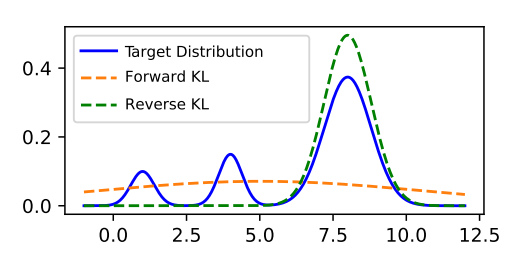

[Gu et al., 2023](https://arxiv.org/abs/2307.09158), [Agarwal et al., 2024](https://arxiv.org/abs/2306.13649), [Kim et al., 2024](https://www.mdpi.com/2227-7390/12/17/2647), show that RKL can be more suitable than FKL for aligning logits from LLMs because it avoids learning too many long-tail variants and focuses the student on the main modes of the teacher. The described behaviors and experiments were, however, analyzed under assumptions that the student distribution is unimodal (e.g., Gaussian), and that both teacher and student distributions are continuous. In the knowledge distillation for LLMs, these
conditions do not hold, since student distribution is not guaranteed to be unimodal and teacher and student distributions are discrete.

On top of previous work, [Wu et al., 2024](https://arxiv.org/pdf/2404.02657) show that although the mentioned assumptions do not stand for LLMs, the optimization objective of FKL and RKL is actually the same. Their experiments indicate that the two methods differ mainly in the beggining of the training-i.e. FKL focuses more on the head (high-probability) part of the teacher distribution, while RKL focuses more on the tail (low-probability) part. However, after sufficient number of epochs, they observed that both methods converge to the same objective. Therefore, switching from FKL to RKL or vice-versa primarily changes the training dynamics, and not the final convergence.




<hr style="border:10px solid green"> </hr>
</font></h4>

**You need to ensure you restarted the kernel and have sufficiently free memory (no 7B model running)**

check with `! nvidia-smi`

In [ ]:
! nvidia-smi

Sat Nov 22 22:25:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             34W /   70W |   14784MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----




This code is very basic, and allows you to test a training over the small number of samples you've generated. Due to limitations of Google Colab we cannot go much further, but this first part should have given you the basics on how to perform white-box distillation.

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 4: Complete The Training Code</br>

<hr style="border:10px solid blue"> </hr>
</font></h4>


- Loss function
- gradient accumulation handling



In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm.auto import tqdm
import torch
from torch.utils.data import DataLoader
import numpy as np


student_model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-0.5B-Instruct"
).cuda() # To Complete
dataset = QwenKLDataset(path_h5="logprobs.h5", path_jsonl="conversations_rag.jsonl") # To Complete

num_epochs = 2
grad_accum_steps = 8
optimizer = torch.optim.AdamW(student_model.parameters(), lr=5e-5)
loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=lambda x: x[0])
num_training_steps = num_epochs * len(loader) // grad_accum_steps
scheduler = get_linear_schedule_with_warmup(optimizer, 0, num_training_steps)
loss_fn = torch.nn.KLDivLoss(reduction="batchmean", log_target=True) # To Complete

student_model.train()
for epoch in range(num_epochs):
    epoch_loss, steps = 0, 0
    for i, batch in enumerate(loader):
        outputs = student_model(batch["inputs"]["input_ids"])
        answer_start, answer_end = batch["idx_subseq"], batch["idx_subseq"] + batch["seq_len"] # get the indices of answer

        student_logits = outputs.logits[0, answer_start:answer_end, :].float() # get logits for the answer
        student_logprobs = torch.nn.functional.log_softmax(student_logits, dim=-1)
        teacher_logprobs = batch["labels"]

        batch_loss = loss_fn(student_logprobs, teacher_logprobs) / grad_accum_steps # divide the loss by grad_accum_steps
        batch_loss.backward()
        # To Complete
        if (i + 1) % grad_accum_steps == 0 or (i + 1) == len(loader):
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            print (f"Epoch {epoch+1}, step {i+1}/{len(loader)}: loss = {batch_loss.item():.4f}")

        epoch_loss += batch_loss.item()
        steps += 1
    # print(f"Epoch {epoch+1}: loss = {outputs.loss.item():.4f}")
    print(f"Epoch {epoch+1}: loss = {epoch_loss/steps:.4f}")

student_model.save_pretrained("finetuned_model")
tokenizer.save_pretrained("finetuned_model")


config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

0it [00:00, ?it/s]

Epoch 1, step 8/185: loss = 0.0179
Epoch 1, step 16/185: loss = 0.1361
Epoch 1, step 24/185: loss = 0.0734
Epoch 1, step 32/185: loss = 0.9319
Epoch 1, step 40/185: loss = 0.0965
Epoch 1, step 48/185: loss = 0.1093
Epoch 1, step 56/185: loss = 0.0786
Epoch 1, step 64/185: loss = 0.0620
Epoch 1, step 72/185: loss = 0.1114
Epoch 1, step 80/185: loss = 0.0705
Epoch 1, step 88/185: loss = 0.0238
Epoch 1, step 96/185: loss = 0.0203
Epoch 1, step 104/185: loss = 0.0821
Epoch 1, step 112/185: loss = 0.0240
Epoch 1, step 120/185: loss = 0.0541
Epoch 1, step 128/185: loss = 0.0798
Epoch 1, step 136/185: loss = 0.1120
Epoch 1, step 144/185: loss = 0.1085
Epoch 1, step 152/185: loss = 0.0134
Epoch 1, step 160/185: loss = 0.0300
Epoch 1, step 168/185: loss = 0.0135
Epoch 1, step 176/185: loss = 0.0084
Epoch 1, step 184/185: loss = 0.0137
Epoch 1, step 185/185: loss = 0.3263
Epoch 1: loss = 0.1050
Epoch 2, step 8/185: loss = 0.0222
Epoch 2, step 16/185: loss = 0.0457
Epoch 2, step 24/185: loss = 0.

OutOfMemoryError: CUDA out of memory. Tried to allocate 520.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 510.12 MiB is free. Process 7237 has 14.24 GiB memory in use. Of the allocated memory 11.53 GiB is allocated by PyTorch, and 2.58 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Part 2 - Retrieval Augmented Generation (RAG)

In this section, we will discuss the concept of **Retrieval-Augmented Generation (RAG)** — a framework that combines **information retrieval** and **language generation**. RAG enables language models to access **external knowledge sources** at inference time, reducing hallucinations and improving factual accuracy.

We will explore how to:
- Build and index a **Vector database** from a corpus (here: Wikipedia sample).
- Retrieve the most relevant documents given a query using **embedding-based similarity**.
- Integrate retrieval results into the **generation pipeline** to produce context-aware answers.


In [ ]:
# restart the session and run
!pip install "numpy>=2,<=2.3" datasets==2.21.0 pandas==2.2.2 chromadb==0.4.22

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.0/509.0 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━

In [ ]:
!pip -q install torch tqdm jsonlines h5py
!pip -q install --upgrade transformers accelerate vllm
!pip install jedi

In [ ]:
!pip install numpy==1.26.4 --force-reinstall --no-deps
!pip install chromadb==0.4.22 datasets==2.21.0 pandas==2.2.2


  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


  Using cached chromadb-0.4.22-py3-none-any.whl.metadata (7.3 kB)
  Using cached datasets-2.21.0-py3-none-any.whl.metadata (21 kB)
  Using cached build-1.3.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached chroma-hnswlib-0.7.3.tar.gz (31 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.0/509.0 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.4 MB/s eta 0:00:00
   ━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pathlib

target_dir = pathlib.Path("/content/drive/MyDrive/altegrad_lab5")
target_dir.mkdir(parents=True, exist_ok=True)

target_dir

import sys, os

sys.path.insert(0, str(target_dir))
os.chdir(target_dir)

print("cwd:", os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cwd: /content/drive/MyDrive/altegrad_lab5


In [ ]:
import os
import json
import random
import torch
import pandas as pd
import torch.nn.functional as F
from tqdm import tqdm
from datasets import load_dataset
from IPython.display import display, HTML
from transformers import AutoTokenizer, AutoModel

In [ ]:
# --- Configuration ---
SEED = 42
NUM_ROWS = 1000
DATA_PATH = "wikipedia_20231101_en_1000.csv"

if os.path.exists(DATA_PATH):
    print(f"✅ Found existing dataset at {DATA_PATH}")
    df = pd.read_csv(DATA_PATH)
else:
    print("⏳ Generating new dataset from Wikimedia (English, 2023-11-01)...")
    random.seed(SEED)

    # Load the Wikipedia dataset
    stream_ds = load_dataset(
        "wikimedia/wikipedia",
        "20231101.en",
        split="train",
        streaming=True
    )

    buffered_stream = stream_ds.shuffle(seed=SEED, buffer_size=200_000)

    sampled = []
    for ex in buffered_stream:
        try:
            if int(ex["id"]) % 2 == 0:
                sampled.append(ex)
            if len(sampled) >= NUM_ROWS:
                break
        except:
            continue

    # Create DataFrame
    df = pd.DataFrame(sampled)[["id", "url", "title", "text"]]
    df.to_csv(DATA_PATH, index=False)
    print(f"💾 Dataset saved to {DATA_PATH}")


✅ Found existing dataset at wikipedia_20231101_en_1000.csv


In [ ]:
#Display Basic Info ---
print("Sampled shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())

Sampled shape: (1000, 4)
Columns: ['id', 'url', 'title', 'text']


,id,url,title,text
0,64741026,https://en.wikipedia.org/wiki/Indrani%20Perera,Indrani Perera,Indrani Perera (Sinhala:ඉන්ද්‍රානි පෙරේරා: bor...
1,66847582,https://en.wikipedia.org/wiki/August%20Laur,August Laur,August Laur (9 October 1886 Vana-Põltsamaa Par...
2,66467526,https://en.wikipedia.org/wiki/Daniele%20Solcia,Daniele Solcia,Daniele Solcia (born 7 March 2001) is an Itali...
3,65913988,https://en.wikipedia.org/wiki/Eric%20Takabatake,Eric Takabatake,Eric Takabatake (born 9 January 1991) is a Bra...
4,64723650,https://en.wikipedia.org/wiki/Nafissath%20Radji,Nafissath Radji,Nafissath Radji (born 2 August 2002 in Porto-N...


In [ ]:
# Visualize Random Wikipedia Articles ---

NUM_EXAMPLES = 3  # number of random samples to show
samples = df.sample(NUM_EXAMPLES, random_state=random.randint(0, 10000))

for _, row in samples.iterrows():
    display(HTML(f"""
    <hr style="border:2px solid #ccc">
    <h3><b>Title:</b> {row['title']}</h3>
    <p><b>URL:</b> <a href="{row['url']}" target="_blank">{row['url']}</a></p>
    <p style="text-align: justify;"><b>Text:</b><br>{row['text']}</p>
    """))


### **Document Chunking**

The first step in building a RAG pipeline is **chunking**, where large documents are divided into smaller, semantically coherent pieces.  
Chunking allows the retriever to work on manageable text segments instead of entire documents, improving retrieval precision and reducing computational load.  


<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 1: Naive Fixed-Length Chunking  
Split each document into overlapping fixed-length chunks to prepare text for retrieval.
<hr style="border:10px solid blue"> </hr>
</font></h4>


In [ ]:

def text_splitting(text, chunk_length=300, chunk_overlap=100):
    """
    Splits text into fixed-length chunks with overlap.
    """
    out = []
    stride = chunk_length - chunk_overlap ## FILL THE GAP: define the stride as the effective step between chunks
    for i in range(0, len(text), stride):
        chunk = text[i:i+chunk_length] ## FILL THE GAP: extract a substring of size 'chunk_length' starting at 'i'
        out.append(chunk)
    return out

# Apply to all documents
df["naive_chunks"] = df["text"].apply(lambda t: text_splitting(t, chunk_length=300, chunk_overlap=100))

num_chunks = df["naive_chunks"].apply(len)
print(f"Average number of chunks per document: {num_chunks.mean():.2f}")
print(f"Total number of chunks: {num_chunks.sum()}")

example_idx = 0
print("\n--- Example document ---")
print("Title:", df.iloc[example_idx]["title"])
print("Original length:", len(df.iloc[example_idx]["text"]))
print("Number of chunks:", len(df.iloc[example_idx]["naive_chunks"]))
print("\nFirst 2 chunks:\n")
for i, c in enumerate(df.iloc[example_idx]["naive_chunks"][:2]):
    print(f"Chunk {i+1}:\n{c[:400]}\n{'-'*80}")

Average number of chunks per document: 11.50
Total number of chunks: 11498

--- Example document ---
Title: Indrani Perera
Original length: 3012
Number of chunks: 16

First 2 chunks:

Chunk 1:
Indrani Perera (Sinhala:ඉන්ද්‍රානි පෙරේරා: born 15 February), is a Sri Lankan singer and playback singer. Indrani along with Clarence Wijewardena and Annesley Malewana are known as "The Original Sinhala Pop Trio".

Early life 
She was born on 15 February in Borella, and is the second of three girls 
--------------------------------------------------------------------------------
Chunk 2:
la Pop Trio".

Early life 
She was born on 15 February in Borella, and is the second of three girls in the family. Her father, Abeypala Perera was a Buddhist and mother, Muriel Perera was a Christian. She has one elder sister, Mallika and one younger sister, Iranganie. Indrani studied at  Presbyteri
--------------------------------------------------------------------------------


<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 2: Paragraph-Aware Chunking  
Implement a smarter chunking strategy by using the ('.') as a boundary to split text into sentences or short paragraphs, then regroup them until reaching the desired chunk length.
<hr style="border:10px solid blue"> </hr>
</font></h4>


In [ ]:
def text_splitting_paragraph(text, chunk_length=300):
    """
    Splits text by sentences/paragraphs (using '.' as boundary)
    and groups them until reaching the desired chunk length.
    """
    out = []
    paragraph_list = text.split(".") ## FILL THE GAP: split the text into smaller parts using '.' as a separator
    current_text = ""
    length = 0
    for par in paragraph_list:
        par = par.strip()
        # we add + 1 because we concatenate '.' and ' ' because of stripping
        if length != 0 and length + len(par) + 1 < chunk_length:
            current_text += " " + par + "." ## FILL THE GAP: extend the ongoing chunk with the next segment
            length += len(par) + 1 ## FILL THE GAP: increment the total length accordingly
        else:
            if len(current_text) != 0:
                out.append(current_text) ## FILL THE GAP: store the current completed chunk before starting a new one)
            current_text = " " + par + "." ## FILL THE GAP: initialize a new chunk with the current paragraph
            length = len(par) + 1 ## FILL THE GAP: reset the chunk length counter
    if len(current_text) > 0:
        out.append(current_text) ## FILL THE GAP: add the last remaining chunk to the list)
    return out


# Apply to all documents
df["paragraph_chunks"] = df["text"].apply(lambda t: text_splitting_paragraph(t, chunk_length=300))

# Compute stats
num_chunks_par = df["paragraph_chunks"].apply(len)
print(f"Average number of paragraph-based chunks per document: {num_chunks_par.mean():.2f}")
print(f"Total number of paragraph-based chunks: {num_chunks_par.sum()}")

# Example comparison
example_idx = 432 #Check out other examples
print("\n--- Example document ---")
print("Title:", df.iloc[example_idx]['title'])
print("Original length:", len(df.iloc[example_idx]['text']))
print(f"Character based chunks: {len(df.iloc[example_idx]['naive_chunks'])}")
print(f"Paragraph based chunks: {len(df.iloc[example_idx]['paragraph_chunks'])}")

print("\nParagraph chunk preview:\n")
for i, c in enumerate(df.iloc[example_idx]['paragraph_chunks'][:6]):
    print(f"Chunk {i+1}:\n{c[:400]}\n{'-'*80}")


Average number of paragraph-based chunks per document: 8.88
Total number of paragraph-based chunks: 8878

--- Example document ---
Title: John Ballantine (banker)
Original length: 12204
Character based chunks: 62
Paragraph based chunks: 50

Paragraph chunk preview:

Chunk 1:
 John Ballantine (1743–1812), was a Scottish merchant and banker and one of the greatest friends, admirers and closest confidants of Robert Burns.
--------------------------------------------------------------------------------
Chunk 2:
 Significantly Ballantine gave the poet advice on the selection of poems for his First Kilmarnock Edition as well as being asked for his opinion on the bard's poems. Life and character
John was born in Ayr to William Ballantine, a baillie in Ayr and his mother was Elizabeth Bowman.
--------------------------------------------------------------------------------
Chunk 3:
 He was a merchant and a Banker and in 1787 he became the Provost of Ayr, during which time he helped establish Ay

<b><h4><font color='red'>

<hr style="border:10px solid red"> </hr>  
Question 1:  
In the paragraph-aware chunking method above, we simply split Wikipedia text using the '.' delimiter to approximate sentence boundaries.  
Discuss whether this is an effective strategy for creating meaningful chunks in a RAG system.
Propose one or more improved chunking strategies that could better capture document structure — and you may include code snippets to justify or demonstrate your approach.  
<hr style="border:10px solid red"> </hr>  
</font></h4>


<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 1: </b><br>

Chunking using '.' as the delimeter is basically a sentence splitting approach, but they differ since the '.' character can also appear in some abbrevations (e.g. dr.) or numbers (e.g. 1.234). In general, for both our method and pure sentence based approach, there are several limitations:
- Splitting each sentence produces a large number of short chunks. Processing of these chunks can lead to increased computational workload.  
- Individual sentence often contains small amount of information, thus the system can struggle to retrieve or reason the answer.  
- Answer, context and definition can span over multiple sentences. Sentences will therefore lose their meaning when taken out from their broader context, which leads to context loss and less coherent outputs.
- In our case, Wiki documents contain much more than just sentences (e.g. section titles, tables), which this splitting method does not support.

To alleviate these issues, we can use topic based chunking, where the text is split based on semantic topics rather than punctuation. In this approach, chunks are grouped by meaning, and each chunk represents a unified topic. This makes retrieval easier for the system because each chunk is topically cohesive and more meaningful/information giving. Additionally, it is less likely that the system will return partial or incorrect information, since the semantic meaning and context are better preserved and not broken across different chunks.

Previous approach solves our initial limitations, yet it introduces new ones of its own. For example, it requires the use of external models (e.g. vectorizer or K-means clustering) to identify the topics, which can be resource and computationally expensive. If we want an improvement over the initial approach but still stay close to it, we can combine the original idea with the method used earlier in the assignment and apply a sliding window across sentences. This approach would preserve more context in each chunk and reduce the possibility of information splitting across more chunks.
<hr style="border:10px solid green"> </hr>
</font></h4>

<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 2: Consider a scenario where you want to perform RAG on source code (e.g., Python files, Java classes) instead of natural language text. Would the chunking methods demonstrated above (character-based and sentence/paragraph based with boundaries) work effectively for code? Explain why or why not, and describe how you would approach chunking source code to maintain semantic coherence. What specific characteristics of code structure would you need to consider?

<hr style="border:10px solid red"> </hr>
</font></h4>

<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 2: </b><br>

Neither of previous chunking methods would work effectively for code. In characted-based chunking, the logical units (e.g. statements, loops, functions, classes) can be separated into different chunks and thus result in incomplete and misleading semantic information. Additionally, sentence-based chunking with '.' as a delimeter would be even less effective. This way, our code would most commonly be split between the class' method or attribute calls, or even floating point values, which would produce either too short or too long chunks that would in either way miss the context. Moreover, paragraph-based chunking using blank lines as delimeters would also likely fail since the coding and formatting styles vary accross the datasets.

To maintain semantic coherence when chunking source code, our proposed approach would be to use the abstract syntax tree (AST; for Python) or parsers (for Java). These tools produce a structured, hierarchial and semantically connected representation of the code from which we can further process it and perform logically coherent chunking. Each node in the representation tree corresponds to logical units such as variables, keywords, functions, classes, etc. Nodes are connected based on parent-child relationships that represent how statements and blocks are organized in the code.

We now only need to consider the characteristics of the code structure based on which we want to do the chunking. Some of them are as follows:
- Keeping the function signature, docstrings and body together so the chunk is completely meaningful.
- Including import lines in non-import code chunk. Code can depend on the import at the top of the file, which if not included can break the context.
- Keeping the `if`, `for`, `while`, or `try-catch` blocks together. For instance, separating an `if` block from its corresponding `else` block would break the logical unit.
- Keeping variable definitions together with the code that depends on them.

Based on these rules, we can traverse the AST and group nodes into chunks that contain much more context than the previous approaches would provide.

<hr style="border:10px solid green"> </hr>
</font></h4>

In [ ]:
# Saving chunks ---

# Flatten chunks into a new DataFrame
records = []
for _, row in df.iterrows():
    doc_id = row["id"]
    title = row["title"]
    url = row["url"]
    for i, chunk in enumerate(row["paragraph_chunks"]):
        records.append({
            "doc_id": doc_id,
            "title": title,
            "url": url,
            "chunk_id": f"{doc_id}_chunk_{i}",
            "chunk_text": chunk.strip()
        })

# Create the flattened chunks DataFrame
chunks_df = pd.DataFrame(records)
print(f"Total chunks: {len(chunks_df)}")
print(f"Average chunk length: {chunks_df['chunk_text'].apply(len).mean():.2f} characters\n")

# Show example
print("Example rows:")
display(chunks_df.head())

chunks_df.to_csv("wikipedia_chunks.csv", index=False)
print("Chunks saved to 'wikipedia_chunks.csv'")
print(f"Total chunks: {len(chunks_df)}")


Total chunks: 8878
Average chunk length: 246.64 characters

Example rows:


,doc_id,title,url,chunk_id,chunk_text
0,64741026,Indrani Perera,https://en.wikipedia.org/wiki/Indrani%20Perera,64741026_chunk_0,Indrani Perera (Sinhala:ඉන්ද්‍රානි පෙරේරා: bor...
1,64741026,Indrani Perera,https://en.wikipedia.org/wiki/Indrani%20Perera,64741026_chunk_1,Early life \nShe was born on 15 February in Bo...
2,64741026,Indrani Perera,https://en.wikipedia.org/wiki/Indrani%20Perera,64741026_chunk_2,Indrani studied at Presbyterian Girls School ...
3,64741026,Indrani Perera,https://en.wikipedia.org/wiki/Indrani%20Perera,64741026_chunk_3,She met him during the production of his song ...
4,64741026,Indrani Perera,https://en.wikipedia.org/wiki/Indrani%20Perera,64741026_chunk_4,After that he studied A/L at the Royal Institu...


Chunks saved to 'wikipedia_chunks.csv'
Total chunks: 8878


## <b>Part II: Embedding</b>

After chunking our documents, the next step is to convert text chunks into vector representations (embeddings). These embeddings capture the semantic meaning of the text in a high-dimensional space, allowing us to measure similarity between chunks and queries mathematically.

We will use **sentence-transformers/all-MiniLM-L6-v2**, a compact and efficient embedding model that produces 384-dimensional embeddings for English text. This model offers a strong balance between performance and computational efficiency, making it well-suited for our RAG pipeline.


<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 3: </b><br>
Fill in the <code>embed()</code> function to encode text chunks and generate normalized embeddings using <code>sentence-transformers/all-MiniLM-L6-v2</code>.  
Then, apply it to all documents in <code>chunks_df</code> and store the results.
<hr style="border:10px solid blue"> </hr>
</font></h4>


In [ ]:
# --- 2.3 Embedding Generation ---
# Load model
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

print(f"Loaded embedding model: {model_name}")


# --- Define embedding function ---
def embed(text_list, doc_type="document"):
    """
    Encodes a list of texts and returns normalized embeddings.
    """
    encoded = tokenizer(
        [f"search_{doc_type}: {t}" for t in text_list],
        padding=True,
        truncation=True,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        output = model(**encoded) ## FILL THE GAP: forward pass through the model to obtain hidden states
        token_embeddings = output.last_hidden_state ## FILL THE GAP: extract the last hidden state from the output
        pooled = torch.sum(token_embeddings, dim=1) ## FILL THE GAP: aggregate token embeddings (e.g., by summing along sequence dimension)
        pooled = torch.nn.functional.normalize(pooled) ## FILL THE GAP: apply L2 normalization along the embedding dimension

    return pooled.cpu()



tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loaded embedding model: sentence-transformers/all-MiniLM-L6-v2


In [ ]:
# --- Test with one example ---
sample_text = ["Artificial intelligence is transforming the world."]
sample_emb = embed(sample_text)
print(f"Sample embedding shape: {sample_emb.shape}")

# --- Apply to all chunks ---
print(f"\nGenerating embeddings for {len(chunks_df)} chunks...")

emb_list = []
for i in tqdm(range(0, len(chunks_df), 32)):
    batch = chunks_df["chunk_text"].iloc[i:i+32].tolist()
    emb = embed(batch, doc_type="document")
    emb_list.append(emb)

chunk_embeddings = torch.cat(emb_list, dim=0).numpy()
chunks_df["embedding"] = list(chunk_embeddings)

print("\nEmbeddings generated and added to DataFrame.")
print(chunks_df[["chunk_id", "title", "embedding"]].head())

Sample embedding shape: torch.Size([1, 384])

Generating embeddings for 8878 chunks...


100%|██████████| 278/278 [00:13<00:00, 20.67it/s]



Embeddings generated and added to DataFrame.
           chunk_id           title  \
0  64741026_chunk_0  Indrani Perera   
1  64741026_chunk_1  Indrani Perera   
2  64741026_chunk_2  Indrani Perera   
3  64741026_chunk_3  Indrani Perera   
4  64741026_chunk_4  Indrani Perera   

                                           embedding  
0  [-0.0708645, -0.031503566, -0.005814116, -0.02...  
1  [-0.012864295, -0.019443626, -0.028137444, 0.0...  
2  [-0.06029346, -0.036576908, 0.018930344, 0.026...  
3  [-0.07509218, -0.0029661183, -0.00598709, 0.03...  
4  [-0.037770636, -0.033015274, 0.018825978, 0.02...  


<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 3: In most retrieval systems, embeddings are represented as fixed-size vectors. Can you think of a way to design embeddings that can flexibly adjust their size or level of detail while still preserving meaningful similarity between representations? How could such an approach benefit Retrieval-Augmented Generation (RAG) systems in practice, particularly for improving efficiency or adapting to different computational budgets?

<hr style="border:10px solid red"> </hr>
<i>Hint:</i> You can find the answer in the paper <a href="https://arxiv.org/pdf/2205.13147" target="_blank">Matryoshka Representation Learning</a>.
</font></h4>


<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 3: </b><br>

[Kusupati et al., 2022](https://arxiv.org/pdf/2205.13147) show that it is possible for a single embedding to contain coarse-to-fine representations that are at least as accurate and expressive as independently trained low-dimensional embeddings. They do this by learning one $d$-dimensional vector $z_{d}$, for which every $z_{1:m}$ vector is trained to be an independently capable, transferable, and general purpose representation of the datapoint $x$. Here, $m$ denotes the embedding dimension from the set $M \subset [d]$, where $M$ is the nested representation set. Their objective optimizes a multi-class classification loss for each nested dimension, after which these single losses are aggregated. As a result, the smaller dimension embeddings become strong global descriptors on their own, while the higher dimensional embeddings add additional, finer details. The major advantage of this approach is that a single embedding can adapt to the computational constraints of downstream task.

We aim to take advantage of this approach in RAG systems by applying it to multi-stage querying. This method retrieves data in different, successive stages, starting with smaller embeddings and gradually increasing the embedding size. Initially, the system searches over smaller embeddings, which provides immediate speedups and computational savings since low-dimensional similarity search is much faster. Once the first stage is done, we retrieve the top-k most similar embeddings from the database. In the second stage, we then perform the search using larger embeddings for only those selected chunks from the first stage. Since the expensive search is restricted to a much smaller subset of data, we can obtain the higher accuracy associated with larger embeddings while maintaining low computational cost. This is the precise benefit for RAG systems.


<hr style="border:10px solid green"> </hr>
</font></h4>

### **Building a Simple Vector Database**

After generating embeddings for all our document chunks, the next step is to **store** them in a structure that allows fast similarity search.  
In this section, we will build a **simple in-memory vector database** using PyTorch tensors.  
Each entry in the database will correspond to a text chunk and its embedding, enabling efficient retrieval based on vector similarity.


<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 4: </b><br>
Fill in the code to populate the database by computing embeddings for all text chunks in <code>chunks_df</code> using the <code>embed()</code> function.
<hr style="border:10px solid blue"> </hr>
</font></h4>


In [ ]:

def populate_database(chunks_df, batch_size=16):
    """
    Populates a vector database from precomputed chunks_df.
    """
    n_chunks = len(chunks_df)

    sample_emb = embed([chunks_df["chunk_text"].iloc[0]], doc_type='document') ## FILL THE GAP: compute one sample embedding to infer the output dimension
    output_dim = sample_emb.shape[1] ## FILL THE GAP: extract the embedding dimension from the sample

    vectorial_database = torch.empty((n_chunks, output_dim), dtype=sample_emb.dtype) ## FILL THE GAP: initialize an empty tensor to store all embeddings
    chunk_list = chunks_df["chunk_text"].tolist()

    print(f"Populating vector database with {n_chunks} chunks...")

    n = 0
    for i in range(0, n_chunks, batch_size):
        batch = chunk_list[i:i+batch_size] ## FILL THE GAP: select a batch of chunk texts
        embeddings = embed(batch, doc_type="document") ## FILL THE GAP: compute embeddings for the current batch
        vectorial_database[n:n+len(batch)] = embeddings ## FILL THE GAP: store embeddings in the tensor
        n += len(batch)

    return chunk_list, vectorial_database



In [ ]:
#Build Vector Database
chunk_list, vectorial_database = populate_database(chunks_df)

print("\n✅ Vector database successfully built.")
print(f"Total stored chunks: {len(chunk_list)}")
print(f"Database tensor shape: {tuple(vectorial_database.shape)}")

Populating vector database with 8878 chunks...

✅ Vector database successfully built.
Total stored chunks: 8878
Database tensor shape: (8878, 384)


In [ ]:
#Save vector databse
os.makedirs("vector_db", exist_ok=True)

# Save tensor + chunk list
torch.save(vectorial_database, "vector_db/vectorial_database.pth")

with open("vector_db/chunk_list.json", "w", encoding="utf-8") as f:
    json.dump(chunk_list, f, indent=4, ensure_ascii=False)

print("✅ Saved:")
print(" - vector_db/vectorial_database.pth")
print(" - vector_db/chunk_list.json")

✅ Saved:
 - vector_db/vectorial_database.pth
 - vector_db/chunk_list.json


In [ ]:
# Load the database
vectorial_database = torch.load("vector_db/vectorial_database.pth", map_location=device)
vectorial_database.requires_grad_(False)

with open("vector_db/chunk_list.json", "r", encoding="utf-8") as f:
    chunk_list = json.load(f)

print(f"✅ Loaded {len(chunk_list)} chunks.")
print(f"Database shape: {vectorial_database.shape}\n")

# Inspect first few entries
for i, embedding_vector in enumerate(vectorial_database[:5]):
    print(f"Vector {i} → {embedding_vector[:5]}")
    print(f"Text snippet: {chunk_list[i][:300]}\n")


✅ Loaded 8878 chunks.
Database shape: torch.Size([8878, 384])

Vector 0 → tensor([-0.1097, -0.0133, -0.0467, -0.0494, -0.0300], device='cuda:0')
Text snippet: Indrani Perera (Sinhala:ඉන්ද්‍රානි පෙරේරා: born 15 February), is a Sri Lankan singer and playback singer. Indrani along with Clarence Wijewardena and Annesley Malewana are known as "The Original Sinhala Pop Trio".

Vector 1 → tensor([-0.0152, -0.0011, -0.1108,  0.0976, -0.0439], device='cuda:0')
Text snippet: Early life 
She was born on 15 February in Borella, and is the second of three girls in the family. Her father, Abeypala Perera was a Buddhist and mother, Muriel Perera was a Christian. She has one elder sister, Mallika and one younger sister, Iranganie.

Vector 2 → tensor([-0.0936, -0.0453, -0.0106, -0.0055, -0.0743], device='cuda:0')
Text snippet: Indrani studied at  Presbyterian Girls School in Regent Street. She studied Kandyan Dancing in the school. Her sister Mallika has been singing since 1965 where she was the playba

#### **Defining Similarity Metrics for Retrieval**

After populating our vector database with embeddings, the next step in a RAG pipeline is to define a *similarity metric* to measure how close two vectors are in the embedding space.  
Common metrics include **dot product**, **L2 distance**, and **cosine similarity**.  

In most retrieval systems, cosine similarity is preferred because it measures the *angle* between two vectors rather than their magnitude, allowing comparison based purely on semantic direction instead of scale.


<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 5: </b><br>
Fill in the code to implement the <code>cosine_similarity()</code> function.  
<hr style="border:10px solid blue"> </hr>
</font></h4>


In [ ]:
def cosine_similarity(query_embeddings, doc_embeddings):
    """
    Computes cosine similarity between query and document embeddings
    using manual normalization.
    """
    query_magnitudes = torch.linalg.vector_norm(query_embeddings, dim=1, keepdim=True) ## FILL THE GAP: calculate vector length for each query
    normalized_queries = query_embeddings / query_magnitudes ## FILL THE GAP: normalize queries using their magnitudes

    doc_magnitudes = torch.linalg.vector_norm(doc_embeddings, dim=1, keepdim=True) ## FILL THE GAP: calculate vector length for each document
    normalized_docs = doc_embeddings / doc_magnitudes ## FILL THE GAP: normalize documents using their magnitudes

    similarity_matrix = normalized_queries @ normalized_docs.T ## FILL THE GAP: perform dot product between normalized queries and documents

    return similarity_matrix


# --- Example test ---
query_embeddings = embed([
    "What is t-SNE?",
    "Who is Laurens van der Maaten?"
], "query")

doc_embeddings = embed([
    "t-SNE is a dimensionality reduction algorithm created by Laurens van der Maaten."
], "document")

with torch.no_grad():
    sim_cos = cosine_similarity(query_embeddings, doc_embeddings)

print("🔍 Example cosine similarity scores:\n", sim_cos)

🔍 Example cosine similarity scores:
 tensor([[0.6605],
        [0.4333]])


<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 6: </b><br>
Fill in the code to complete the <code>retrieve()</code> function.  
It should encode the input query using <code>embed()</code>, compute similarity with all vectors in <code>vectorial_database</code>, and return the top-<i>k</i> most similar text chunks.
<hr style="border:10px solid blue"> </hr>
</font></h4>


In [ ]:
def retrieve(query,
             vectorial_database=vectorial_database,
             chunk_list=chunk_list,
             topk=5,
             verbose=False):
    """
    Retrieves top-k most similar chunks to a query using dot-product similarity.
    """
    with torch.no_grad():
        query_embedding = embed([query], doc_type="query") ## FILL THE GAP: encode the input query using the embed() function
        query_embedding = query_embedding.to(vectorial_database.device) ## FILL THE GAP: move the query embedding to the correct device
        similarity_scores = cosine_similarity(query_embedding, vectorial_database) ## FILL THE GAP: compute similarity between query and database embeddings
        topk_results = torch.topk(similarity_scores, k=topk, dim=1) ## FILL THE GAP: extract the top-k highest similarity scores and indices

        if verbose:
            for score, idx in zip(topk_results.values[0], topk_results.indices[0]):
                print(f"\nScore: {score:.4f}")
                print(f"Chunk:\n{chunk_list[idx][:500]}\n{'-'*80}")

        retrieved_chunks = [chunk_list[i] for i in topk_results.indices[0]] ## FILL THE GAP: select text chunks corresponding to the top-k indices
        return "\n".join(retrieved_chunks) ## FILL THE GAP: return concatenated retrieved chunks as a single string


In [ ]:
# Example query
query = "When was Luigi Boria born?" #Try different queries based on the documents in the wikipedia dataset
result = retrieve(query, topk=3, verbose=True)



Score: 0.5924
Chunk:
Luigi Boria (born April 23, 1958) is a Venezuelan-born American politician who served as mayor of Doral, Florida from 2012 to 2016. Boria defeated former Miami-Dade School Board member Frank Bolaños in the 2012 elections, obtaining 54% of the vote.
--------------------------------------------------------------------------------

Score: 0.5618
Chunk:
(1675–1684)
 Sede vacante (March 1684–August 1686)
 Nicolò Caranza (1686–1697)
 Giulio Della Rosa (1698–1699)
 Alessandro Roncoveri (1700–1711)
 Adriano Sermattei (1713–1719)
 Gherardo Zandemaria (1719–1731)
 Severino Antonio Missini (1732–1753)
 Girolamo Bajardi (1753–1775)
 Alessandro Garimberti (1776–1813)
Sede vacante (1813–1817)
 Aloisio San Vitale (1817–1836)
 Giovanni Tommaso Neuschel (1836–1843)
 Pier Grisologo Basetti (1843–1857)
Sede vacante (16 June 1857 – 20 June 1859)
 Francesco Ben
--------------------------------------------------------------------------------

Score: 0.5207
Chunk:
Biography 
Boria, who 

<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr> Question 4: There are retrieval methods like BM25 that rely on lexical overlap between the query and documents, and others based on dense embeddings that capture semantic similarity beyond exact word matches. Explain how these two approaches differ in how they represent and compare text. Then, discuss how a hybrid retrieval strategy combining both can overcome their respective limitations and improve retrieval performance in RAG systems. <hr style="border:10px solid red"> </hr> </font></h4>

<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 4: </b><br>

BM25 and similar methods represent text as high-dimensional vectors. These methods encode the presence or absence of specific words, which produces vectors with many zero dimensions, so they are called sparse retrieval methods. For the dimensions that are non zero, their values are computed using term weighting functions such as TF-IDF or BM25 scores. These functions measure how often a word appears in the document and how rare it is across the corpus. The text is compared with exact (lexical) matching which can indeed be a limitation in certain cases. For example, the methods can struggle to retrieve documents containing synonyms or paraphrases (e.g. 'cheap' and 'low cost').

On the other hand, dense retrieval methods represent text as a lower-dimensional vectors encoded by neural networks. These methods allow the model to capture semantic meaning and measure the similarity between words even if they are not lexically the same, which is the advantage over sparse methods. The text is compared through similarity scores, such as cosine similarity or dot-product scores. However, since the representations of words is learned, these methods may struggle with specific and rare entities that do not appear frequently in the training data.

Now, by combining the advantages of both approaches, we can build a hybrid strategy that combines the keyword, lexical precision of sparse methods with contextual understanding of dense methods. As seen, sparse methods guarantee that exact and rare terms are not overlooked, while dense method provide semantic flexibility and contextual information even when the wording is paraphrased. We can therefore build a retrieval pipeline in which we would combine (e.g. summing, ranking) the individual scores into one and thus overcome the limitations of each method. One possible approach to hybrid strategy would be the reciprocal rank fusion proposed by [Cormack et al., 2009](https://cormack.uwaterloo.ca/cormacksigir09-rrf.pdf).

<hr style="border:10px solid green"> </hr>
</font></h4>


In real-world RAG systems, instead of manually storing and comparing vectors, we rely on **vector databases** such as **ChromaDB**, which are optimized for efficient **similarity search**, **indexing**, and **retrieval** at scale.  

These databases provide:
- Fast nearest-neighbor search (e.g., using HNSW graphs)  
- Persistent storage for millions of embeddings  
- Built-in support for different similarity metrics (cosine, L2, inner product)  


In [ ]:
import chromadb
from chromadb.config import Settings

# --- Initialize ChromaDB client ---
chroma_client = chromadb.Client(Settings(
    anonymized_telemetry=False,
    allow_reset=True
))

# Reset ensures a clean state
chroma_client.reset()

# --- Create a collection ---
# You can choose the similarity metric: "cosine", "l2", or "ip" (inner product)
collection_name = "wikipedia_chunks"
collection = chroma_client.create_collection(
    name=collection_name,
    metadata={"hnsw:space": "cosine"}  # cosine similarity works best for normalized embeddings
)

print(f"✅ Created collection: {collection_name}")


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


✅ Created collection: wikipedia_chunks


In [ ]:
# Prepare the data
ids = chunks_df["chunk_id"].tolist()
embeddings = chunks_df["embedding"].tolist()
documents = chunks_df["chunk_text"].tolist()

# Ensure all embeddings are plain Python lists
embeddings = [e.tolist() if hasattr(e, "tolist") else e for e in embeddings]

# Add useful metadata for inspection
metadatas = [
    {
        "doc_id": row["doc_id"],
        "title": row["title"],
        "url": row["url"]
    }
    for _, row in chunks_df.iterrows()
]

# Add to the collection
collection.add(
    ids=ids,
    embeddings=embeddings,
    documents=documents,
    metadatas=metadatas
)

print(f"\n✅ Added {collection.count()} chunks to the collection")
print(f"Collection metadata: {collection.metadata}")


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionAddEvent: capture() takes 1 positional argument but 3 were given



✅ Added 8878 chunks to the collection
Collection metadata: {'hnsw:space': 'cosine'}


In [ ]:
# Encode the query using our embed() function
query = "When was Luigi Boria born?"
query_embedding = embed([query], doc_type="query")[0].tolist()  # get single vector as list

# Query the collection
results = collection.query(
    query_embeddings=[query_embedding],
    n_results=3 # number of retrieved results
)

# Display results
print(f"🔎 Query: {query}\n" + "=" * 80)
for i in range(len(results["documents"][0])):
    print(f"\nResult {i+1}:")
    print(f"Title: {results['metadatas'][0][i]['title']}")
    print(f"Similarity score: {1 - results['distances'][0][i]:.4f}")  # cosine distance → similarity
    print(f"Text: {results['documents'][0][i][:300]}...")
    print("-" * 80)


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


🔎 Query: When was Luigi Boria born?

Result 1:
Title: Luigi Boria
Similarity score: 0.5924
Text: Luigi Boria (born April 23, 1958) is a Venezuelan-born American politician who served as mayor of Doral, Florida from 2012 to 2016. Boria defeated former Miami-Dade School Board member Frank Bolaños in the 2012 elections, obtaining 54% of the vote....
--------------------------------------------------------------------------------

Result 2:
Title: Roman Catholic Diocese of Fidenza
Similarity score: 0.5618
Text: (1675–1684)
 Sede vacante (March 1684–August 1686)
 Nicolò Caranza (1686–1697)
 Giulio Della Rosa (1698–1699)
 Alessandro Roncoveri (1700–1711)
 Adriano Sermattei (1713–1719)
 Gherardo Zandemaria (1719–1731)
 Severino Antonio Missini (1732–1753)
 Girolamo Bajardi (1753–1775)
 Alessandro Garimberti (...
--------------------------------------------------------------------------------

Result 3:
Title: Luigi Boria
Similarity score: 0.5207
Text: Biography 
Boria, who is also an evangeli

<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 5: </b><br>
ChromaDB and other vector databases often rely on Hierarchical Navigable Small World (HNSW) graphs to perform efficient approximate nearest neighbor search.  
Explain how the HNSW algorithm organizes data to enable fast and accurate retrieval in high-dimensional spaces.  
Why is this structure particularly effective for large-scale embedding collections compared to brute-force search?

<hr style="border:10px solid red"> </hr>
<i>Reference:</i> <a href="https://arxiv.org/pdf/1603.09320" target="_blank">Efficient and Robust Approximate Nearest Neighbor Search using Hierarchical Navigable Small World Graphs</a>
</font></h4>


<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 5: </b><br>

For LLM and RAG systems, HNSW graphs represent each embedding vector as a node, where each node is connected to its nearest neighbors based on similarity scores. The full graph is organized as multiple graphs in hierarchical layers, in which we distinguish two types:
- Bottom layer: Contains all vectors, is relatively dense, and is mainly responsible for accuracy.
- Top layers: Contain fewer (only a subset of) vectors, are much sparser, and are mainly responsible for fast traversal.

The maximum level graph for each vector is determined by exponentially decaying probability, thus, most nodes appear only in lower layers.

After the data is organized, the query search begins at the top layer with an initial entry node (vector). The algorithm uses greedy search-i.e. it looks at the neighbors of the current node and moves to the one closest to the query. This process is repeated on the same layer until no neighbor is closer to the query than the current node. Then the search moves one layer down, using the current node as the entry point, and the search is repeated on each layer until the bottom layer is reached. Finally, the search on the bottom layer fine-tunes the results for higher accuracy and collects the final nearest neighbors.

Since HNSW uses a hierarchical structure, the querying in ChromaDB scales logarithmically. In contrast, brute-force search compares the query to all vectors and therefore has a time complexity of $O(N)$, which becomes very slow at large scale. Moreover, the recall and accuracy when using HNSW remain high even though the nearest neighbours are approximated. HNSW can also support a large number of vectors efficiently and can perform well across different embedding dimensions. When everything is put together, the HNSW is clearly more efficient then the brute-force approach.


<hr style="border:10px solid green"> </hr>
</font></h4>


### <b> Two-Stage Retrieval: Dense Retrieval + Reranker</b>

In RAG, the first retrieval step often returns passages that are similar in meaning but not always the most relevant.  
A **reranker** fixes this by re-evaluating the top retrieved chunks using a stronger model that jointly reads the query and each document to assign a more accurate relevance score.


In [ ]:
from sentence_transformers import CrossEncoder

# Load reranker model
RERANKER_MODEL_NAME = "cross-encoder/ms-marco-MiniLM-L-6-v2"
reranker = CrossEncoder(RERANKER_MODEL_NAME)

def retrieve_with_reranker(query, collection, initial_k=5, final_k=3):
    """
    Retrieves and reranks candidate documents for a given query.
    Returns both the initial dense results and reranked results.
    """
    query_embedding = embed([query], doc_type="query")[0].tolist()
    candidates = collection.query(query_embeddings=[query_embedding], n_results=initial_k)

    docs = candidates["documents"][0]
    metas = candidates["metadatas"][0]
    dense_scores = [(1 - s) for s in candidates["distances"][0]]

    pairs = [(query, d) for d in docs]
    ce_scores = reranker.predict(pairs)

    reranked = [
        {
            "title": metas[i].get("title", ""),
            "url": metas[i].get("url", ""),
            "text": docs[i],
            "dense_score": dense_scores[i],
            "rerank_score": float(ce_scores[i]),
        }
        for i in range(len(docs))
    ]
    reranked.sort(key=lambda x: x["rerank_score"], reverse=True)

    return docs, metas, dense_scores, reranked[:final_k]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

In [ ]:
# Example usage
query = "Where did Luigi Boria study?" #Try other queries too
docs, metas, dense_scores, top_reranked = retrieve_with_reranker(
    query=query,
    collection=collection,
    initial_k=5,
    final_k=3
)

# --- Display initial dense retrieval ---
print(f"\nInitial dense retrieval (Top 5):\n" + "=" * 80)
for i, (d, s, m) in enumerate(zip(docs, dense_scores, metas), 1):
    print(f"{i}. {m.get('title', '')}  |  Dense similarity: {s:.4f}")
    print(f"Text: {d[:300].replace('\n', ' ')}")
    print("-" * 80)

# --- Display top reranked results ---
print(f"\nAfter Cross-Encoder Reranking (Top 3):\n" + "=" * 80)
for i, item in enumerate(top_reranked, 1):
    print(f"{i}. {item['title']}")
    print(f"Dense similarity: {item['dense_score']:.4f} | Reranker score: {item['rerank_score']:.4f}")
    print(f"Text: {item['text'][:300].replace('\n', ' ')}")
    print("-" * 80)


Initial dense retrieval (Top 5):
1. Luigi Boria  |  Dense similarity: 0.5225
Text: Luigi Boria (born April 23, 1958) is a Venezuelan-born American politician who served as mayor of Doral, Florida from 2012 to 2016. Boria defeated former Miami-Dade School Board member Frank Bolaños in the 2012 elections, obtaining 54% of the vote.
--------------------------------------------------------------------------------
2. Luigi Boria  |  Dense similarity: 0.4986
Text: Biography  Boria, who is also an evangelical Christian pastor, was born in Caracas in 1958 to Italian parents who emigrated to that country. He studied accounting at the Andrés Bello Catholic University, a private institution, in 1982.
--------------------------------------------------------------------------------
3. Luigi Boria  |  Dense similarity: 0.4716
Text: In 1989 he left Venezuela to settle in Doral, Florida, where he currently lives. Boria has run various companies in both Venezuela and the United States since the 1980s.

![Bi-Encoder vs Cross-Encoder Architecture](https://raw.githubusercontent.com/UKPLab/sentence-transformers/master/docs/img/Bi_vs_Cross-Encoder.png)

<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 6:  
The figure above compares a Bi-Encoder and a Cross-Encoder architecture.  
Rerankers such as <code>cross-encoder/ms-marco-MiniLM-L-6-v2</code> use the second approach, jointly encoding the query and document through a single transformer.  
Why does this joint encoding typically yield higher retrieval precision, and why is it applied as a second-stage reranker instead of being used directly for large-scale retrieval?
<hr style="border:10px solid red"> </hr>
</font></h4>


<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 6: </b><br>

In a Bi-Encoder model, the query and document are encoded separately using two transformer encoders, and their embeddings are then compared using a similarity function. Although this approach is efficient for large-scale retrieval because document embeddings can be precomputed, it can limit retrieval quality. This is because the query and document never interact through their hidden-state representation during the encoding, which results in loss of (richer) information.

In contrast, the Cross-Encoder model processes both the query and document together by passing them through a single transformer encoder. The vectors can attend to and interact with each other's hidden states, which allows the model to better extract more meaningful information and learn token-level relationships. This is why Cross-Encoder typically yields higher retrieval precision.

However, the reason why the Cross-Encoder is used as a second-stage reranker lies in its computational cost. With a Cross-Encoder, a full forward pass must be run for every query–document pair. Moreover, it is not possible for document representations to be precomputed once and reused since they are query dependent. Based on this, we can see that the computation for large-scale data would practically be infeasible. Therefore, to avoid this limitation and still benefit from higher precision, it is better to use a cheaper first-stage retriever (e.g., a Bi-Encoder) to retrieve a smaller set of top candidates, after which the Cross-Encoder is applied only to this subset to rescore them more accurately. This approach enables the high precision of joint encoding while maintaining low computational cost.

<hr style="border:10px solid green"> </hr>
</font></h4>


### **Integrating Retrieved Context into the LLM’s Prompt**

Now that we can retrieve and rerank the most relevant document chunks,  
we integrate them directly into the **language model’s prompt**.  
This step allows the model to **ground its answer on factual context** rather than relying solely on internal knowledge —  
thereby improving accuracy and reducing hallucinations.


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

gen_model_name = "Qwen/Qwen2.5-0.5B-Instruct"
gen_tok = AutoTokenizer.from_pretrained(gen_model_name, trust_remote_code=True)
gen_model = AutoModelForCausalLM.from_pretrained(
    gen_model_name,
    device_map="auto",
    dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    trust_remote_code=True
)

def generate(msg, max_new_tokens=128, temperature=0.2):
    messages = [{"role": "user", "content": msg}]
    inputs = gen_tok.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(gen_model.device)

    outputs = gen_model.generate(
        inputs,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        top_p=0.9,
        do_sample=True,
        eos_token_id=gen_tok.eos_token_id,
        pad_token_id=gen_tok.pad_token_id if gen_tok.pad_token_id is not None else gen_tok.eos_token_id
    )

    return gen_tok.decode(outputs[0][inputs.shape[-1]:], skip_special_tokens=True).strip()


# ============================================================
# NO-RAG vs WITH RAG
# ============================================================
query = "When was Luigi Boria born?" #Try other queries

print("ORIGINAL PROMPT\n" + "=" * 60)
print(query)

print("\nANSWER WITHOUT RAG\n" + "=" * 60)
print(generate(query))

docs, metas, dense_scores, top_reranked = retrieve_with_reranker(
    query=query,
    collection=collection,
    initial_k=5,
    final_k=3
)

context = "\n\n".join(h["text"] for h in top_reranked)[:1600]
rag_prompt = (
    f"Use only the context to answer. If unknown, say you don't know.\n\n"
    f"Context:\n{context}\n\n"
    f"Question: {query}\nAnswer:"
)

print("\nAUGMENTED PROMPT\n" + "=" * 60)
print(rag_prompt)

print("\nANSWER WITH RAG\n" + "=" * 60)
print(generate(rag_prompt))


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

ORIGINAL PROMPT
When was Luigi Boria born?

ANSWER WITHOUT RAG
Luigi Boria was born on October 17, 1952. He is an Italian-American writer and filmmaker known for his work in the realm of science fiction and fantasy literature. His most famous works include "The Last Man" (1986), "The Time Machine" (1980), and "Dune" (2004). Boria has also written several novels and short stories that have been adapted into films and television shows.

AUGMENTED PROMPT
Use only the context to answer. If unknown, say you don't know.

Context:
Luigi Boria (born April 23, 1958) is a Venezuelan-born American politician who served as mayor of Doral, Florida from 2012 to 2016. Boria defeated former Miami-Dade School Board member Frank Bolaños in the 2012 elections, obtaining 54% of the vote.

Biography 
Boria, who is also an evangelical Christian pastor, was born in Caracas in 1958 to Italian parents who emigrated to that country. He studied accounting at the Andrés Bello Catholic University, a private instit

<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr> Question 7: In the RAG prompt construction step, we simply concatenate the retrieved chunks before the question. Discuss potential issues with this naive approach, such as token limits, redundancy, or irrelevant context dilution. Then, explain how we could select, weight, or summarize the retrieved chunks before injecting them into the prompt to improve generation quality and efficiency. <hr style="border:10px solid red"> </hr> </font></h4>

<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 7: </b><br>

The potential issues of this approach are as follows:
- Token limits: Every LLM has a maximum number of tokens it can process in a single input. By concatenating many chunks, we can exceed this limit and cause the truncation of tokens, which may lead to loss of important information. In our assignment, we partially mitigated the issue by setting `context=...[:1600]`, but this may still cut off relevant text for the retriever.
- Redundancy: When creating chunks, we do so by splitting the paragraphs using '.' as delimeter. This approach can produce multiple chunks with the similar or same information since the chunks were not split based on some higher-level boundaries (e.g. topic-based chunking). If we stack these overlapping chunks, we end up fulfilling the context window with similar information rather then giving it some other relevant and diverse one. Moreover, we can confuse the model and make it become more uncertain or biased toward the redundant content.
- Irrelevant context dilution: In our solution, we simply stack the retrieved chunks without filtering them. As shown by [Qi et al., 2023](https://arxiv.org/pdf/2307.03172), LLMs do not robustly make use of information from long input context that contains loosely related text. By adding too many weakly relevant chunks, we dilute the important information which causes the model to struggle in finding coherent one. They show that using fewer but more relevant documents in the context typically yields the best results.
- Cost: Larger prompts require more computation and introduce higher latency.

In order to improve the generation, we can do one or more of the followings:
- Selection: We can use a technique such as Maximal Marginal Relevance (MMR; [Dumais et al., 1998](https://www.cs.cmu.edu/~jgc/publication/The_Use_MMR_Diversity_Based_LTMIR_1998.pdf)). MMR enables us to select chunks that are relevant to the query, but also diverse with respect to the previously selected ones. By doing so, we can reduce the redundancy and increase the diversity of information in retrieved chunks.
- Weighting/ordering: [Qi et al., 2023](https://arxiv.org/pdf/2307.03172) also show that the best performance is often achieved when relevant information is positioned at the beginning or the end of the input context. Moreover, we can also append the independent scores of retrieved chunks to the input prompt so the model ideally knows how much to trust each chunk. In some other scenarios where we would use multiple data sources, we can also weigh the chunks based on the source reliability (e.g. literature vs FAQs).
- Summarization: We can summarize the lower-ranked chunks and keep the top ranked ones in full. By doing so, we filter the length of irrelevant (or low-value) chunk, remove noise and free space in the context window for more relevant information.
<hr style="border:10px solid green"> </hr>
</font></h4>


#### **To go further**

- Experiment with other chunking methods (e.g., semantic or recursive chunking).  
- Explore **LangChain** and **LlamaIndex** for building modular RAG pipelines.  
- Try **hybrid retrieval** combining sparse (BM25) and dense embeddings.  
- Explore more advanced RAG methods such as **RAG-Fusion**, **Self-RAG**, and **Active-RAG**.  
- Experiment with **Matryoshka Representation Learning** for scalable embeddings.  
- Try **fine-tuning rerankers** or **retrievers** for domain-specific data.  
